# OCR model for reading Captchas
### OCR模型来读取Captchas

原文链接：https://keras.io/examples/vision/captcha_ocr/

## Note：
Captchas （Completely Automated Public Turing test to tell Computers and Humans Apart） 就是验证码。这个案例演示了如何用CNN+RNN+CTC模型完成验证码识别。代码本身难度并不高，但这里需要介绍下 CTC（Connectionist Temporal Classification） 算法，博主原始博客中并没有相关方面的介绍。  

CTC 算法通常用在不等长的语音识别和文本识别中，平时说话无法保证每句话词量一致或者说话时长相等，图像识别中同样如此，如下图所示。音频中每个单词的发声时长不同，每人说话的停顿方式也不同，就像图像中每个单词所占的像素宽度不同一样，那么将图像的宽度视为“时间”，这样的话在讨论相关问题时能方便一些。  

<img src='../images/CV_Img/CTC_voide_img.png'>  

**图像来源：[CTC算法详解](https://blog.csdn.net/michaelshare/article/details/83660557)**

在深度学习中，语句识别最常见的解决方案是 CNN+RNN（CRNN），CTC 算法（功能层）是计算损失的一个层，通常在 RNN 后面，默认情况下说深度学习中的 CTC 算法指的是 RNN+CTC。  

【**注意**】这里的 RNN+CTC 也是分情况的，对于语音识别而言就是 RNN+CTC ，而对于图像识别来说前面还需要一个 CNN 用来提取特征，所以是 CNN+RNN+CTC。同时，RNN 也不一定指的是 RNN 也可以是 LSTM，两者本质上是一个东西。  

对于这个例子而言，模型的结构类似于下图所示。CTC功能层就插在LSTM后面，将图中“**Ttanscription Layer**”替换掉即可。  

<img src='../images/CV_Img/CTC.png'>  

**图片来源:[CNN算法详解](https://blog.csdn.net/michaelshare/article/details/88826043)**

----------

## Introduction

This example demonstrates a simple OCR model built with the Functional API. Apart from combining CNN and RNN, it also illustrates how you can instantiate a new layer and use it as an "Endpoint layer" for implementing CTC loss. For a detailed guide to layer subclassing, please check out [this page](https://keras.io/guides/making_new_layers_and_models_via_subclassing/) in the developer guides.   

该案例演示了一个使用API构建简单的OCR模型，除了结合CNN和RNN之外，还说明了如何实例化一个功能层，并将该功能层用于CTC损失。官方示例参考该 [案例](https://keras.io/guides/making_new_layers_and_models_via_subclassing/)。

--------------

## Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

----------

## Load the data: [Captcha Images](https://www.kaggle.com/fournierp/captcha-version-2-images)

In [2]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   159  100   159    0     0    152      0  0:00:01  0:00:01 --:--:--   153

  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0 8863k    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  3 8863k    3  338k    0     0    98k      0  0:01:30  0:00:03  0:01:27  212k
 60 8863k   60 5330k    0     0  1200k      0  0:00:07  0:00:04  0:00:03 2059k
100 8863k  100 8863k    0     0  1891k      0  0:00:04  0:00:04 --:--:-- 3125k


VScode用户如果在此处下载出现问题的话可以在终端将代理配置上：
```python
set HTTP_PROXY=http://127.0.0.1:7890
set HTTPS_PROXY=http://127.0.0.1:7890
```
我用的clash for windows，默认端口为7890。配置完后重启VScode重新下载。

该数据集非常规整，解压后没有其他多余的东西，每个样本的形状都为(200,50)，并且每个标签均为5个字符串。数据集结构如下：
```python
captcha_images_v2/
    2b827.png  shape=(200,50)
    2bg48.png  shape=(200,50)
    2cegf.png  shape=(200,50)
    ...
```

The dataset contains 1040 captcha files as png images. The label for each sample is a string, the name of the file (minus the file extension). We will map each character in the string to an integer for training the model. Similary, we will need to map the predictions of the model back to strings. For this purpose we will maintain two dictionaries, mapping characters to integers, and integers to characters, respectively.  

该数据集包含1040个png验证码图片。每个样本的标签是一个字符串（文件名）。这里将字符串中的每个字符映射成一个整数来训练模型，同样也需要将模型预测出的整数映射回字符串。为此需要维护两个字典，来实现双向映射。

In [2]:
data_dir = Path("./captcha_images_v2/")

# 获得所有图片的文件名及标签
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
# characters 是文件名中所包含的部分，即为上文中提到的字典

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'2', '6', 'y', 'p', 'b', 'g', 'c', 'w', 'm', 'd', '5', 'n', 'e', 'f', '3', '7', 'x', '8', '4'}


In [3]:
batch_size = 16

# Desired image dimensions 原始图片的长宽
img_width = 200
img_height = 50

# 降采样系数，后面的模型中跟着两次池化，所以这个系数为4，
# 此处需要注意的是，该系数是博主写出来看的，下面的代码并没有使用该变量，称其为“人工智能”
downsample_factor = 4

# Maximum length of any captcha in the dataset 数据集中最大的标签长度
# 由于该数据集每个标签均为5个字符串，所以这一步其实没什么必要，但在实际使用的时候这一步非常重要
max_length = max([len(label) for label in labels])

-----------

## Preprocessing

In [4]:
# Mapping characters to integers 将字符串映射到整数
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters 将整数映射到字符串
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

分割数据集。此处博主首先生成了随机的索引，然后按照默认9:1的比例进行分割。

In [5]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    train_samples = int(size * train_size)

    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

In [6]:
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

下面的代码中有一点需要注意，第五步“将图像进行转置”。因为模型中使用到了RNN的结构，所以需要输入的数据具有“时间”的含义。但要清楚的是，单张独立图像身并没有时间的概念，由于这里使用了 CTC 算法，在 **Note** 部分中提到了可以将图像中字符间距视作语音中的停顿，所以这里才会说：**将时间对应到宽度上**。

In [7]:
def encode_single_sample(img_path, label):
    # 1. Read image 根据文件名读入图片
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale. 解码并转为灰度图
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range. 将像素值域控制在 [0,1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size. 改变图像大小 
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time dimension to correspond to the width of the image.
    # 将图像进行转置，将时间对应到图像宽度上
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers. 将字符串标签映射成数字
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs. 返回一个字典作为模型的输入
    return {"image": img, "label": label}

-------

## Create Dataset objects

下面的代码通过 **from_tensor_slices** 构建 Dataset 类型的数据，并且使用了 map 传入 **encode_single_sample** 函数句柄来对数据进行处理。

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

--------

## Visualize the data

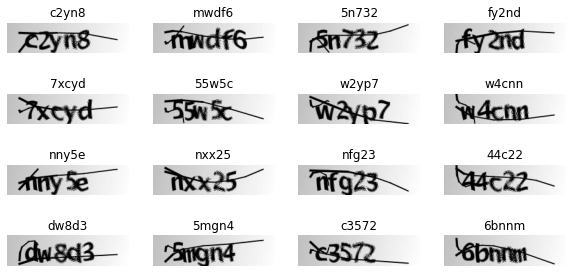

In [9]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

----------

## Model

定义 **CTCLayer** 功能层。此处可以简单说一下里面涉及到的部分内容。  

* **self.loss_fn = keras.backend.ctc_batch_cost** 这里面的 loss_fn 是自定义变量，但直接使用的是 keras 的 ctc_batch_cost 算法。
* **self.add_loss** 方法继承于 [**layers.Layer**](https://keras.io/api/layers/base_layer/#layer-class) 类，允许使用者自行定义这一层的损失函数并计算损失值。

其中比较费解的是为什么允许层能够单独计算损失值，这是为了搭建更复杂模型留下的接口。有时候期望模型到某一层时他的损失很低，同时完整的模型不容易训练或者理论上不收敛，这时就需要分阶段评估模型，有点像微调但和微调不是一个概念。

In [10]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

In [11]:
def build_model():
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # 在经过两次池化后，最后一层的卷积核个数为64，将其输出进行reshape然后送入RNN模型
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # CTC层放置在模型最末尾处
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model

In [12]:
model = build_model()

In [13]:
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

通过查看模型的 summary() 可以注意到最后梁层输出的是一个 50x21 的矩阵：  
```python
dense2 (Dense)      (None, 50, 21)
ctc_loss (CTCLayer) (None, 50, 21)
```
* 第一个维度比较好理解，因为对宽度进行了两次降采样（200像素->50像素），所以第一个维度表示的是在图像纵轴上的映射，可以想象成将图像竖直切成一条一条的一共50条。
* 第二个维度指的是每一条对应在字典上的one-hot向量，字典大小为19，加上开始和结束标识符一共21个。  

前面也提到了 CTC 功能层其实是在计算模型的损失，全连接层通常被认为是决策层，所以下面的代码中在使用模型的时候只用了倒数第二个全链接层。  

可能你会好奇为什么不直接用最后一层的结果作为输出，因为后两层输出的shape完全一致。  

这是因为在 dense 层中使用了 softmax 激活函数对概率进行投票，而在 CTC 功能层中为了切合算法的逻辑，将输入转成了 'int64' 来计算损失，所以最后一层的含义已经变成了损失值矩阵，而不是概率矩阵，同时矩阵的值域是不可控的，为此不能直接使用最后一层的结果。

---------

## Training

In [14]:
epochs = 10
early_stopping_patience = 10

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

In [15]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/10
59/59 [==============================] - 18s 75ms/step - loss: 20.0285 - val_loss: 16.4296
Epoch 2/10
59/59 [==============================] - 2s 40ms/step - loss: 16.3546 - val_loss: 16.3958
Epoch 3/10
59/59 [==============================] - 2s 38ms/step - loss: 16.3403 - val_loss: 16.3920
Epoch 4/10
59/59 [==============================] - 2s 35ms/step - loss: 16.3359 - val_loss: 16.3985
Epoch 5/10
59/59 [==============================] - 2s 35ms/step - loss: 16.3284 - val_loss: 16.3945
Epoch 6/10
59/59 [==============================] - 2s 35ms/step - loss: 16.3272 - val_loss: 16.3976
Epoch 7/10
59/59 [==============================] - 2s 35ms/step - loss: 16.3179 - val_loss: 16.3883
Epoch 8/10
59/59 [==============================] - 2s 35ms/step - loss: 16.2914 - val_loss: 16.3422
Epoch 9/10
59/59 [==============================] - 2s 34ms/step - loss: 16.2032 - val_loss: 16.2248
Epoch 10/10
59/59 [==============================] - 2s 35ms/step - loss: 15.5787 - val_lo

---------

## Inference

此处将上面的模型截取到倒数第二层，即不要最后那个CTC层，重新构建一个模型。

In [16]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

定义一个解码的工具，目的是让人能看得懂模型输出的内容。本质上就是将模型预测出的整数转为字符串再拼接起来

In [17]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

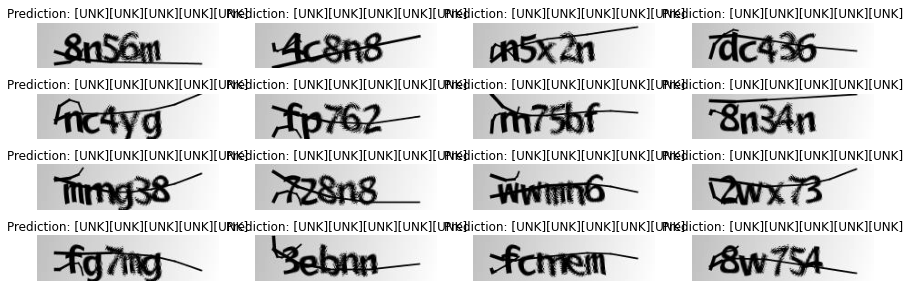

In [18]:
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

我这里训练次数太少了，所以会发现预测结果全都是 '[UNK]' 字符串，有时间的可以多训练几个epoch看看结果。